In [1]:
import matplotlib.pyplot as plt
from src.models import *
from src.model_analysis.utils import same_output
from src.post_quant.cle import cle_for_resmlp
from src.post_quant.bias_absorb import ba_for_resmlp
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels

org_model = resmlp_24(pretrained=True).eval()
model = resmlp_24(pretrained=True)
qmodel = q_resmlp(model)

In [3]:
# test CLE
model = resmlp_24(pretrained=True).eval()
cle_for_resmlp(model)
print(same_output(model, org_model, eps=1e-5))

True


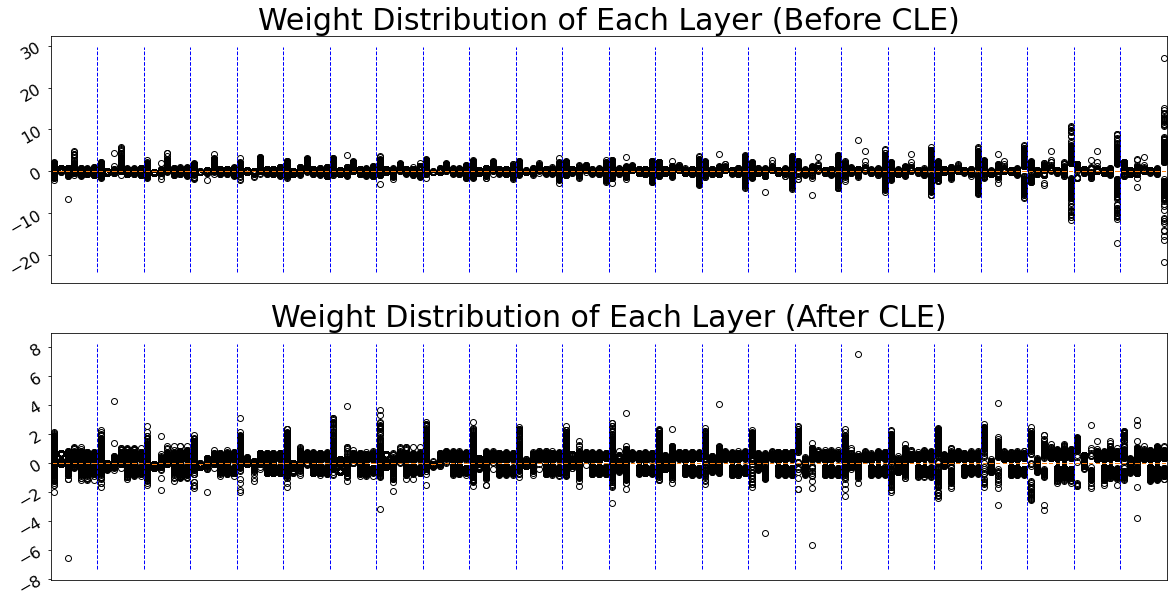

In [4]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

layer_dist(model, 0, 23, name='Weight Distribution of Each Layer (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
# res_cle_for_resmlp(model)
# cle_for_resmlp(model)
layer_dist(model, 0, 23, name='Weight Distribution of Each Layer (After CLE)', ax=ax[1])

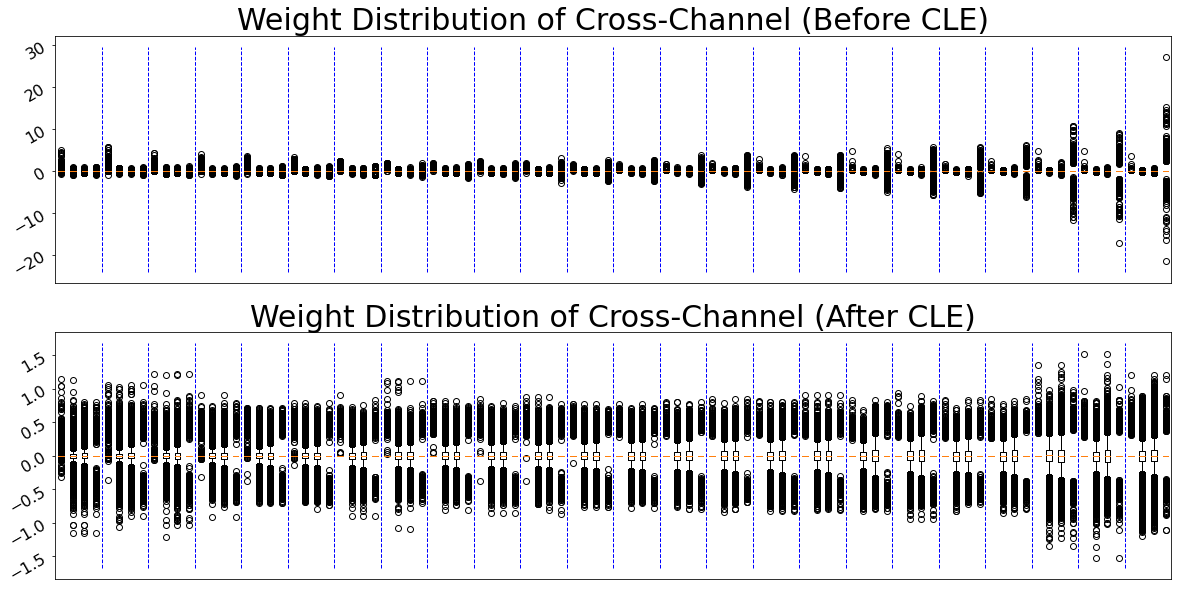

In [3]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

layer_dist(model, 0, 23, show_layers=["norm2", "mlp.fc1", "mlp.fc2", "gamma_2"], name='Weight Distribution of Cross-Channel (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
layer_dist(model, 0, 23, show_layers=["norm2", "mlp.fc1", "mlp.fc2", "gamma_2"], name='Weight Distribution of Cross-Channel (After CLE)', ax=ax[1])

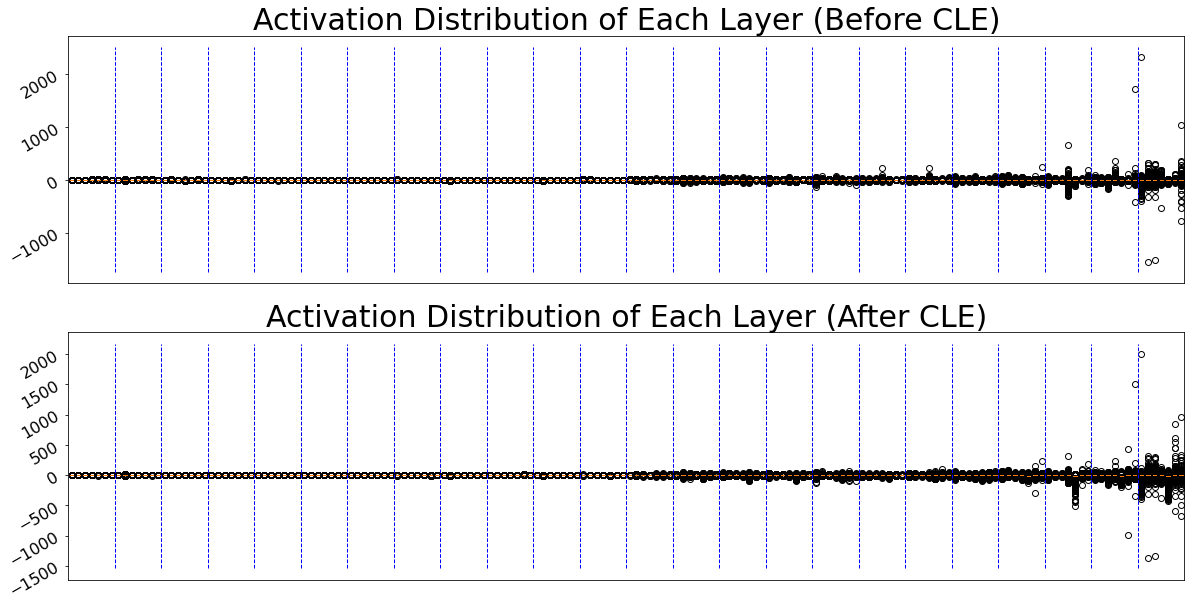

In [9]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='Activation Distribution of Each Layer (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
# q_model = q_resmlp(model)
act_dist(model, 0, 23, name='Activation Distribution of Each Layer (After CLE)', ax=ax[1])

In [10]:
# getattr(model, f"layer0")
for n, m in model.blocks[0].named_modules():
    print(n)


norm1
attn
gamma_1
drop_path
skip_add
skip_add.activation_post_process
norm2
mlp
mlp.fc1
mlp.act
mlp.drop1
mlp.fc2
mlp.drop2
gamma_2


Creating hooks...
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.169 ( 9.169)
Calibrate: [10/21]	Time  0.205 ( 1.028)
Calibrate: [20/21]	Time  0.217 ( 0.640)
Removing hooks...


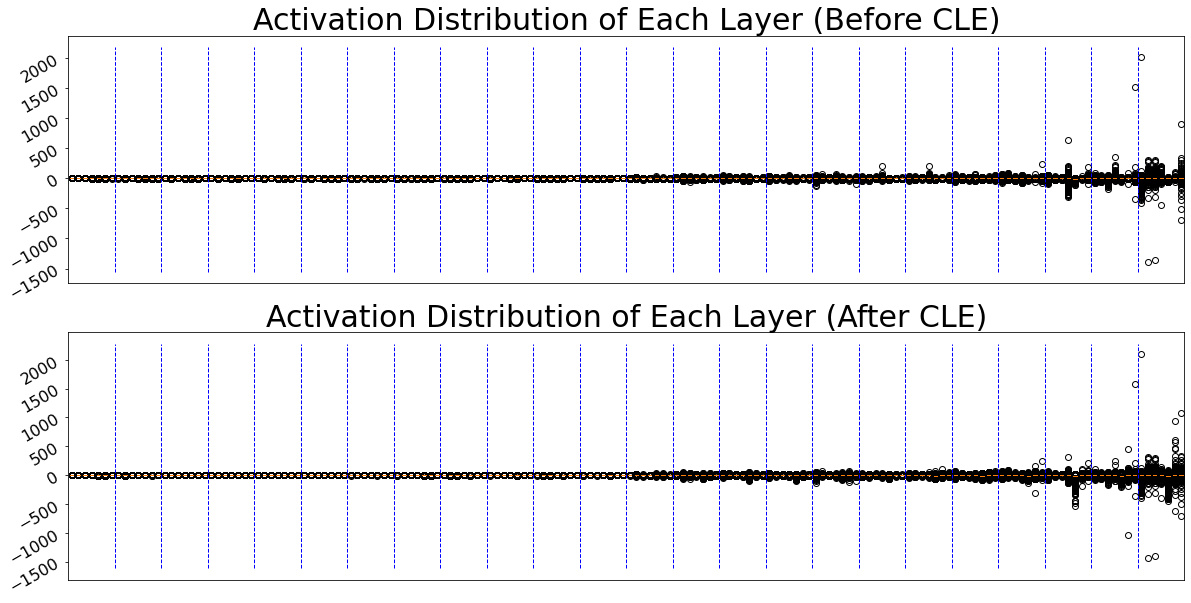

In [8]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='Activation Distribution of Each Layer (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
ba_for_resmlp(model.cuda())
# q_model = q_resmlp(model)
act_dist(model.cpu(), 0, 23, name='Activation Distribution of Each Layer (After CLE)', ax=ax[1])

Creating hooks...
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/41]	Time  8.879 ( 8.879)
Calibrate: [10/41]	Time  0.303 ( 1.104)
Calibrate: [20/41]	Time  0.360 ( 0.732)
Calibrate: [30/41]	Time  0.367 ( 0.618)
Calibrate: [40/41]	Time  0.040 ( 0.549)
Removing hooks...


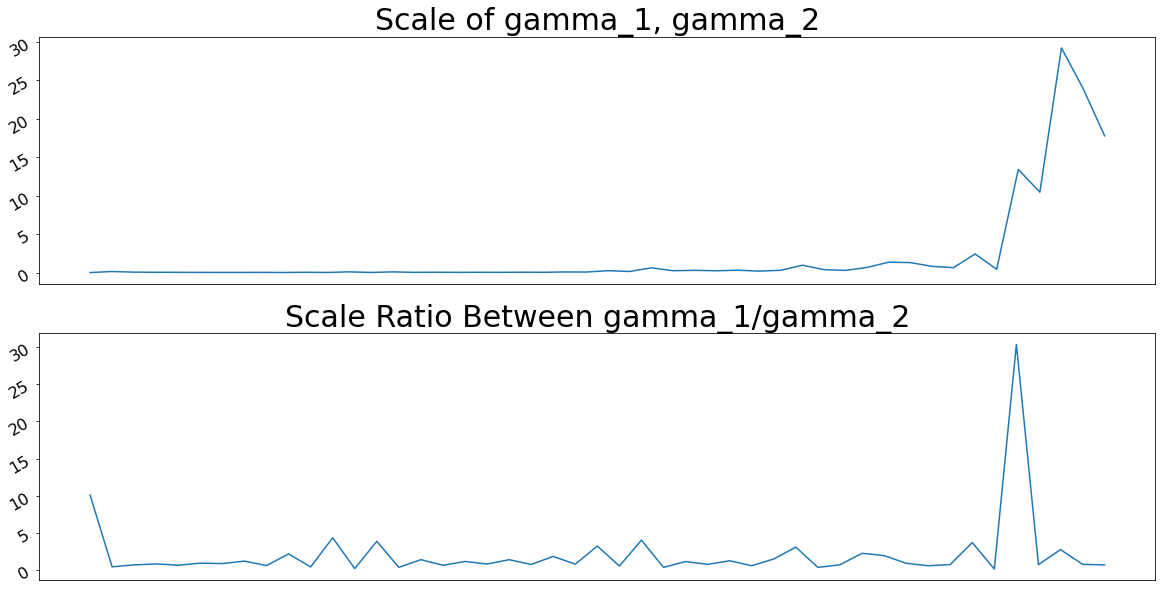

In [14]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

labels, data = scale_plot(model.cuda(), 0, 23, show_layers=["gamma_1", "gamma_2"], name='Scale of gamma_1, gamma_2', ax=ax[0])



In [56]:
CHECKPOINT_PATH = "input8-conv-res16-act8.pth.tar"

model = resmlp_24()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])

for n, m in qmodel.named_modules():
    if isinstance(m, QLinear):
        print(n)

RuntimeError: Attempting to deserialize object on CUDA device 1 but torch.cuda.device_count() is 1. Please use torch.load with map_location to map your storages to an existing device.

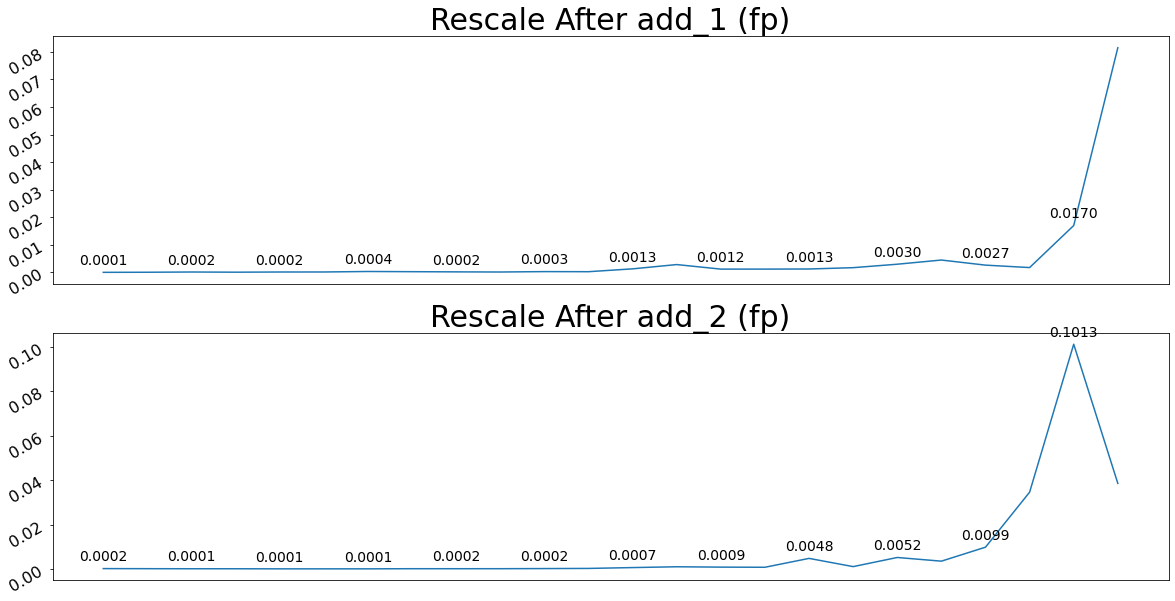

In [39]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.blocks.named_modules():
    if "add_1.observer" in n:
        label_1.append(n)
        data_1.append([m.scale.item()])

ax[0].set_title('Rescale After add_1 (fp)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=2, precision=4)

label_2 = []
data_2 = []
for n, m in qmodel.named_modules():
    if "add_2.observer" in n:
        label_2.append(n)
        data_2.append(m.scale.item())

ax[1].set_title('Rescale After add_2 (fp)', size=30)
ax[1].tick_params(labelrotation=30)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(label_2, data_2)
add_value_labels(ax[1], skip_cnt=2, precision=4)

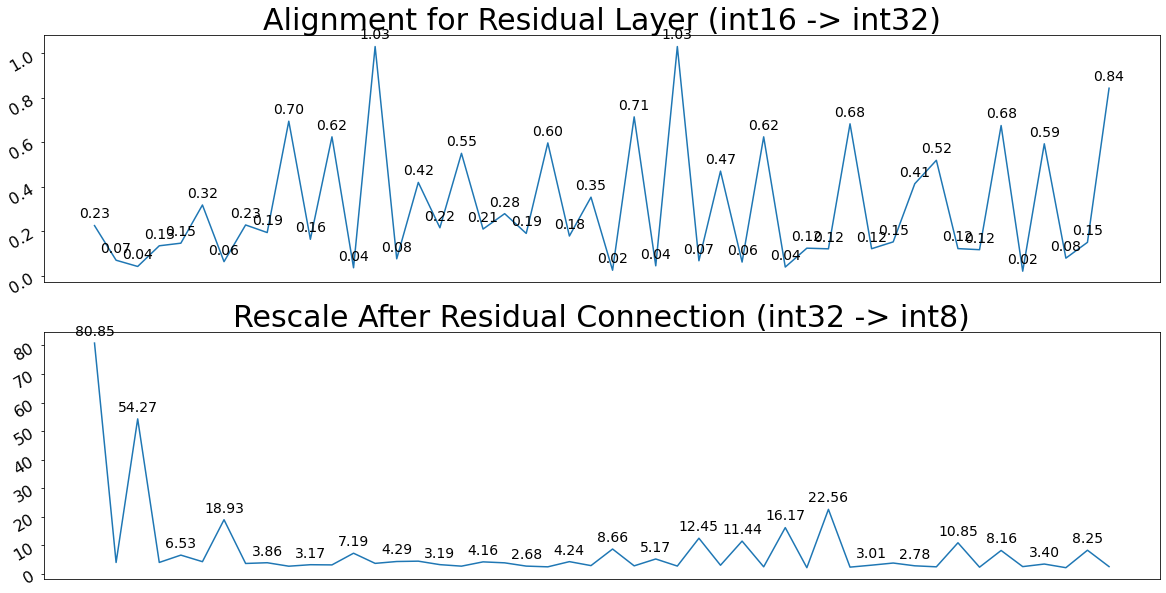

In [40]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.blocks.named_modules():
    if "add" in n and "observer" not in n:
        label_1.append(n)
        scale = (m.res_mult[0].type(torch.double) / (2.0 ** m.res_shift[0]).type(torch.double)).type(torch.float)
        data_1.append(scale)

ax[0].set_title('Alignment for Residual Layer (int16 -> int32)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=1, precision=2)


label_2 = []
data_2 = []
for n, m in qmodel.named_modules():
    if "add" in n and "observer" not in n:
        label_2.append(n)
        scale = (m.mult[0].type(torch.double) / (2.0 ** m.shift[0]).type(torch.double)).type(torch.float)
        data_2.append(scale)

ax[1].set_title('Rescale After Residual Connection (int32 -> int8)', size=30)
ax[1].tick_params(labelrotation=30)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(label_2, data_2)
add_value_labels(ax[1], skip_cnt=2, precision=2)

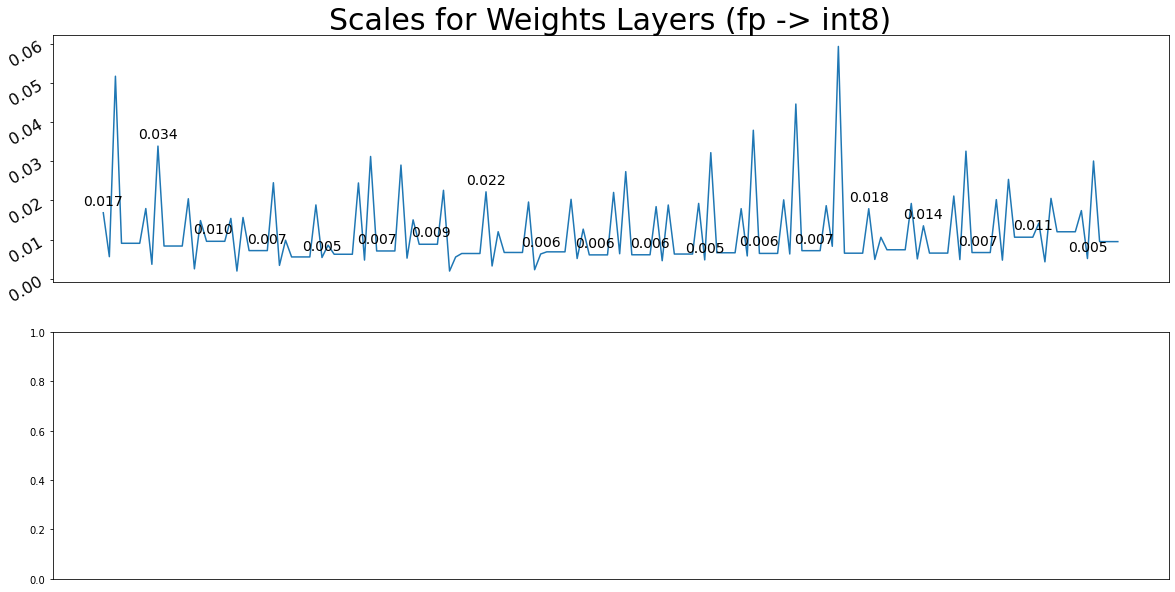

In [55]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.named_modules():
    if isinstance(m, QLinear):
        label_1.append(n)
        data_1.append(m.observer.scale.item())

ax[0].set_title('Scales for Weights Layers (fp -> int8)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=9, precision=3)


# label_2 = []
# data_2 = []
# for n, m in qmodel.named_modules():
#     if "add" in n and "observer" not in n:
#         label_2.append(n)
#         scale = (m.mult[0].type(torch.double) / (2.0 ** m.shift[0]).type(torch.double)).type(torch.float)
#         data_2.append(scale)

# ax[1].set_title('Rescale After Residual Connection (int32 -> int8)', size=30)
# ax[1].tick_params(labelrotation=30)
# for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
#     label.set_fontsize(16)
# ax[1].plot(label_2, data_2)
# add_value_labels(ax[1], skip_cnt=2, precision=2)